In [1]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Perception of amplitude modulation-induced vibrato

Data analysis and exploration. Helper functions follow. Skip to next cell to see results.

In [8]:
# Globals.
MAX_INTEGER = 2**53 - 1

# Helpers.
def normalize_slider(df):
    already_normalized = (df[['response', 'slider_start']] <= 1).all().all()
    if not already_normalized:
        df[['response', 'slider_start']] = df[['response', 'slider_start']] / MAX_INTEGER
    return df

def extract_condition(df):
    if 'condition' not in df:
        def process(x):
            return "_".join(x[-1].split('_')[:-1])
        df['condition'] = df['stimulus'].str.split('/').apply(process)
    return df

def extract_trials(df):
    df = df[df['trial_type'] == 'audio-slider-response']
    df = df[~df['stimulus'].str.contains("train")]
    return df

def extract_subject(df):
    if 'subjectNo' not in df:
        df['subjectNo'] = df['stimulus'].str.split("/").apply(lambda x: x[1].split("_")[1])
    return df

def isolate_study(df, study_type):
    assert not df[df['studyType'] == study_type].empty, 'Returns no trials. Already filtered?'
    return df[df['studyType'] == study_type]

def get_summary(df):
    tmp1 = df[['condition', 'response']].groupby('condition').mean()
    tmp2 = df[['condition', 'response']].groupby('condition').std()

    tmp3 = pd.DataFrame()
    tmp3['mean'] = tmp1['response']
    tmp3['std'] = tmp2['response']
    return tmp3

def load(pattern='./prolific/*.csv'):
    files = glob(pattern)
    assert files, 'No csv data found.'

    df = pd.DataFrame()

    for file in files:
        df = df.append(pd.read_csv(file))
        
    return df

    
def macro(study_type):
    df = load()

    df = isolate_study(df, study_type)
    df = extract_trials(df)
    df = normalize_slider(df)
    df = extract_subject(df)
    df = extract_condition(df)
    df = df.reset_index(drop=True)

    df = get_summary(df)
    return df

def filter_by_control(df, threshold=0.6):
    """Find subjectNo where the CONTROL condition was rated below threshold."""
    tmp1 = df[df['condition'] == 'CONTROL'].groupby(['subjectNo'])['response'].min() > threshold
    tmp2 = tmp1[tmp1]
    print(f"N = {len(tmp2)}")
    return df[df['subjectNo'].isin(tmp2.keys())]

def filter_by_basic(df, threshold=0.6):
    """Find subjectNo where the BASIC condition was rated below threshold."""
    tmp1 = df[df['condition'] == 'BASIC'].groupby(['subjectNo'])['response'].min() > threshold
    tmp2 = tmp1[tmp1]
    print(f"N = {len(tmp2)}")
    return df[df['subjectNo'].isin(tmp2.keys())]

def response_histograms(df,bins=25):
    for i, group in enumerate(df.groupby('condition')['response']):
        plt.subplot(1, 2, (i % 2) + 1)
        plt.title(group[0])
        plt.hist(group[1], bins=bins)
        if (i % 2 == 1):
            plt.show()
            
def min_max_norm(df):
    min_ = df.groupby('subjectNo')['response'].transform('min')
    max_ = df.groupby('subjectNo')['response'].transform('max')
    df['response'] = (df['response'] - min_)/(max_ - min_)
    return df

### Study 1: Perceived fusion.

**Note**: 
Results are min-max normalized per subject.

,mean,std
condition,,
BASIC,0.283868,0.230920
CONTROL,0.823842,0.214081
FM_ONLY,0.648839,0.306427
FROZEN,0.290445,0.217384
PAM,0.800855,0.229898
RAG,0.351403,0.235336
RAG_RAF,0.339307,0.241908
SHUFFLE,0.373763,0.239056
SHUFFLE_RAF,0.332031,0.243205


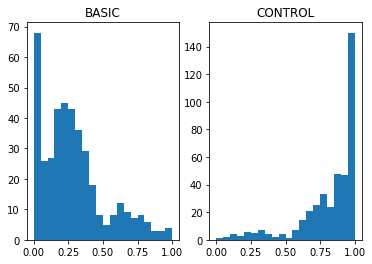

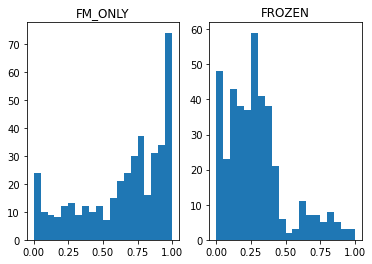

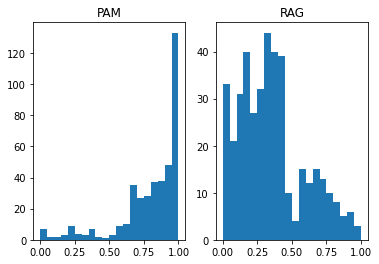

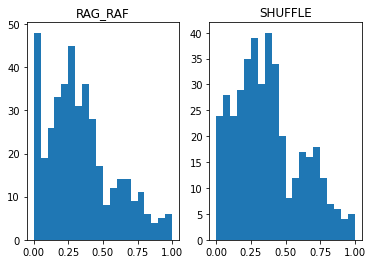

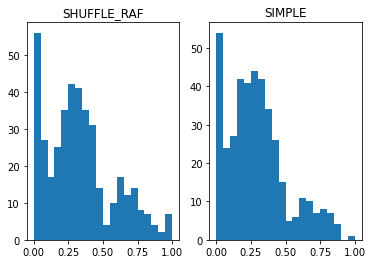

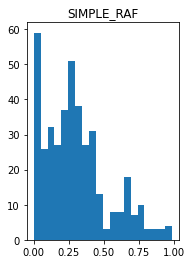

In [10]:
study_type = 0
df = load('./prolific/*.csv')
df = isolate_study(df, study_type)
df = extract_trials(df)
df = normalize_slider(df)
df = extract_subject(df)
df = extract_condition(df)
df = min_max_norm(df)
df = df.reset_index(drop=True)

display(get_summary(df))
response_histograms(df, 20)

### Study 1

Perceived realism.

**Note**:
Ratings are min-max normalized per subject.

,mean,std
condition,,
BASIC,0.635573,0.280864
CONTROL,0.383148,0.319881
FM_ONLY,0.495426,0.313030
FROZEN,0.594353,0.265677
PAM,0.380236,0.313012
RAG,0.571733,0.258197
RAG_RAF,0.513825,0.273695
SHUFFLE,0.554518,0.264120
SHUFFLE_RAF,0.461906,0.281960


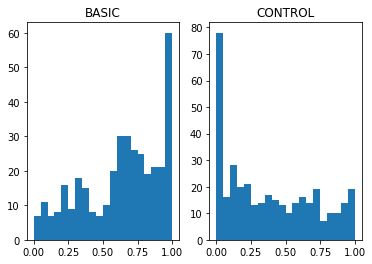

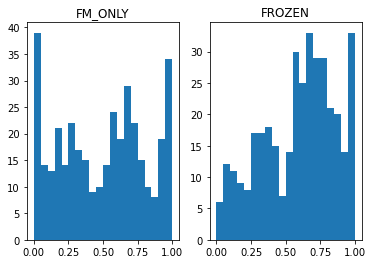

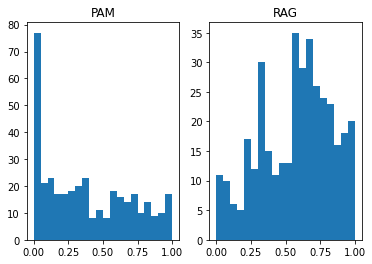

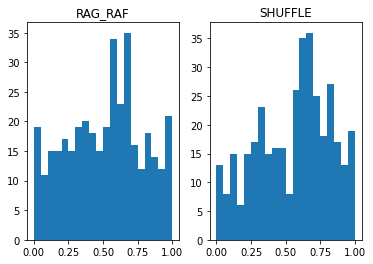

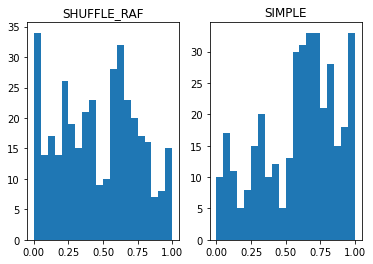

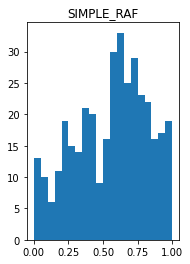

In [12]:
study_type = 1
df = load('./prolific/*.csv')
df = isolate_study(df, study_type)
df = extract_trials(df)
df = normalize_slider(df)
df = extract_subject(df)
df = extract_condition(df)
df = min_max_norm(df)
df = df.reset_index(drop=True)

display(get_summary(df))
response_histograms(df, 20)

### Explorations

In [ ]:
# Consistency within subject (ranking the same thing), then averaged accross.
# I.e., effect of randomization.